# Benchmark Approach for Portfolio Tracking

Our benchmark method will consist of a lasso regression. We have considered two methods each run with and without rebalancing.

The first method consists of using the weights defined by the lasso regression as our final weights. In a second approach we instead use lasso to select the feature and then a simple least squares regression to compute the optimal weights on the selected features.

In [78]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from helper import *
import warnings
warnings.filterwarnings("ignore")

## General Hyperparameters

In [79]:
# Absolute Trading Costs are 5 basis point
ABS_TCOSTS = 0.0005
# Relative Trading Costs are 10 basis points
REL_TCOSTS = 0.0010

# Set the seed for reproducible results
np.random.seed(25)
# np.random.seed(42)

# Rebalancing Parameters
REBALANCE_PERIOD = 120
LAGGED_PERIODS = 3
TOTAL_REBALANCE_DAYS = REBALANCE_PERIOD*LAGGED_PERIODS

# Other
VERBOSE = False

sns.set_palette(["Black"] + sns.color_palette("Paired")[2:])

## Plotting Parameters

In [80]:
FIG_SIZE = (12, 6)

## Importing the Data

We used data from the MSCI world index constituents as our base assets. Assets for which there were NaNs were dropped. This results in a solid dataset with more than 800 assets and almost 20 years of data. We also removed weekends as datapoints as most assets are not traded on weekends.

In [81]:
returns = pd.read_csv('Index_Replication_Data/X_USD.csv', index_col=0, header=0, parse_dates=True, keep_default_na=True, na_values=['NA'], delimiter=';', decimal=",")
returns.dropna(axis=1, inplace=True)
returns = returns[returns.index.dayofweek < 5]

print(returns.index.min(), returns.index.max())
print(returns.shape)

2002-03-06 00:00:00 2023-09-20 00:00:00
(5621, 984)


### Generating a random index

To generate a robust approach, we generate a completely random index using 100 assets of the total dataset, the rest will be available to replicate.

In [82]:
# Usable Assets for Replication
X = returns[returns.columns[:-100]].values

# Random Index to Replicate
index, rweights = generate_index(returns[returns.columns[-100:]])
Y = index

# Create a DataFrame to store the results
results = pd.DataFrame(columns=["Index", "Index - Cumulative", "Lasso Only", "Lasso Only - Cumulative", "Lasso + Least Squares", "Lasso + Least Squares - Cumulative", "Rebalancing and Lasso", "Rebalancing and Lasso - Cumulative", "Rebalancing and Lasso + Least Squares", "Rebalancing and Lasso + Least Squares - Cumilative"], index=returns.index)
results["Index"] = Y
metrics = pd.DataFrame(columns=["Lasso Only", "Lasso + Least Squares", "Rebalancing and Lasso", "Rebalancing and Lasso + Least Squares"], index = ["Tracking Error", "Relative Drawdown", "T-Costs"])
T_costs = pd.DataFrame(columns=["Index", "Rebalancing and Lasso", "Rebalancing and Lasso + Least Squares"])

### Plotting the Random Index Returns and Cumulative Returns

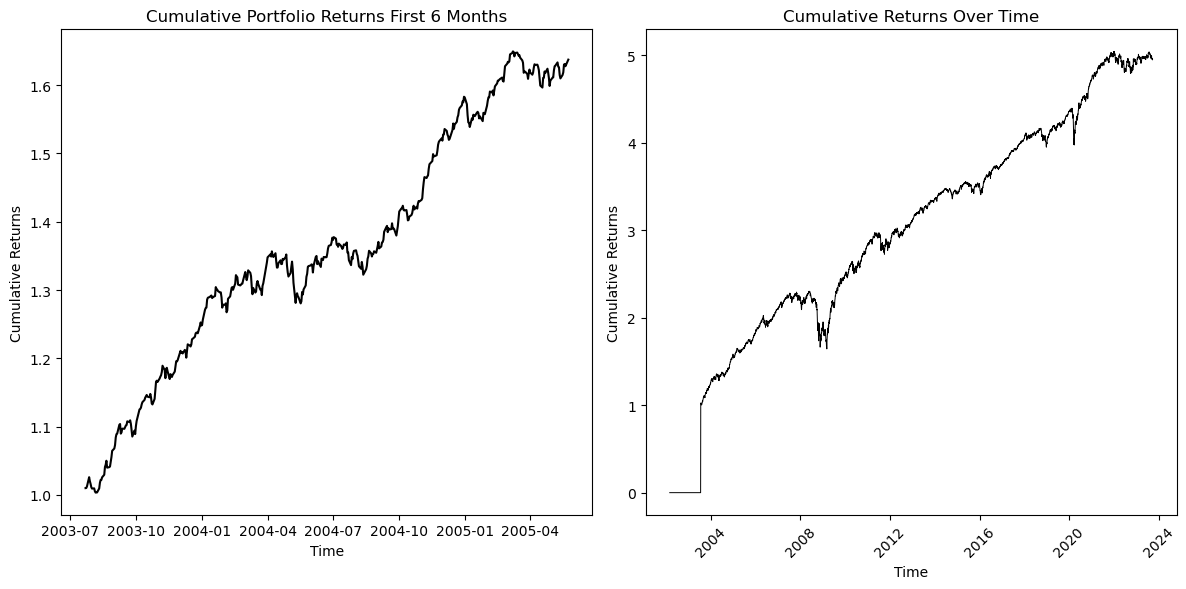

In [83]:
# Calculate cumulative portfolio returns
zero = np.zeros_like(Y)
zero[TOTAL_REBALANCE_DAYS:] = 1 + np.cumsum(Y[TOTAL_REBALANCE_DAYS:])
results["Index - Cumulative"] = zero
T_costs["Index"] = 0

# Plotting
plt.figure(figsize=FIG_SIZE)

plt.subplot(1, 2, 1)
sns.lineplot(data=results["Index - Cumulative"][TOTAL_REBALANCE_DAYS:2*TOTAL_REBALANCE_DAYS + REBALANCE_PERIOD])
plt.title('Cumulative Portfolio Returns First 6 Months')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')

plt.subplot(1, 2, 2)
sns.lineplot(data=results["Index - Cumulative"], linewidth=0.7)
plt.title('Cumulative Returns Over Time')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()

## First Approach: Simple Lasso with no rebalancing and no least squares

### Setting Up the Regression

In [84]:
# Split the data into train and test sets
X_train, Y_train = X[:TOTAL_REBALANCE_DAYS], Y[:TOTAL_REBALANCE_DAYS]
X_test, Y_test = X[TOTAL_REBALANCE_DAYS:], Y[TOTAL_REBALANCE_DAYS:]

days = X_train.shape[0]

folds = int(np.floor(days/REBALANCE_PERIOD))
alpha = np.linspace(10e-9, 5*10e-6, folds) 
validation_itr = TimeSeriesSplit(n_splits=folds).split(X_train, Y_train)
plot = False

min_scorel = np.Infinity
best_alpha = None

### Running the Cross-Validation Phase

In [85]:
# WITHOUT T COSTS, RUN ON REGRESSION1 FUNCTION
for j, (train_idx, test_idx) in enumerate(validation_itr):

    w = regression1(X_train[train_idx], Y_train[train_idx], X_train[test_idx], Y_train[test_idx], alpha[j], plot)
    w = w / np.sum(w)

    Y_pred_lasso = np.dot(X_train[test_idx], w)

    # Evaluate the model
    msel = mean_squared_error(Y_train[test_idx], Y_pred_lasso)

    drawdown = compute_rel_drawdown(Y_pred_lasso)

    num_nonzero_coeffsl = len(w[w != 0])

    scorel = (msel + drawdown)/2

    if VERBOSE:
        print(sum(w))
        print(f"Mean Squared Error for fold {j}: {msel}")
        print(f"Number of non-zero coefficients for fold {j}: {num_nonzero_coeffsl}")
        print(f"Score for fold {j}: {scorel}")
        print("")

    if scorel < min_scorel:
        min_scorel = scorel
        best_alpha = alpha[j]

print(f"The best alpha is: {best_alpha}")

The best alpha is: 2.5005000000000002e-05


### Running the regression with optimal alpha

In [86]:
# Run regression1 on test set with best alpha
lasso_best = regression1(X_train, Y_train, X_test, Y_test, best_alpha)      

# Normalize the weights
lasso_best = lasso_best / np.sum(lasso_best)

#Get mean squared error for best alpha
Y_pred_lasso = np.dot(X_test, lasso_best)
print(f"Number of selected features: {np.count_nonzero(lasso_best)}")
zero = np.zeros_like(Y)
zero[TOTAL_REBALANCE_DAYS:] = Y_pred_lasso
results["Lasso Only"] = zero

mselb = mean_squared_error(Y_test, Y_pred_lasso)
print(f"Mean Squared Error for best alpha on test set: {mselb}")

# Calculate the predicted cumulative return
cum_returns_pred = np.cumsum(Y_pred_lasso)
zero[TOTAL_REBALANCE_DAYS:] = cum_returns_pred
results["Lasso Only - Cumulative"] = 1+zero

# Calculate the real cumulative return
cum_returns_real = np.cumsum(Y[TOTAL_REBALANCE_DAYS:])

gains, losses = compute_gains_losses(cum_returns_real)
pred_gains, pred_losses = compute_gains_losses(cum_returns_pred)

# Calculate MSE for gains and losses
mse_gains = mean_squared_error(gains, pred_gains)
mse_losses = mean_squared_error(losses, pred_losses)

print("MSE for cumulative gains (portfolio value):", mse_gains)
print("MSE for cumulative losses (portfolio value):", mse_losses)

# Calculate the drawdown for test set as before 
drawdown_test = compute_rel_drawdown(cum_returns_pred)

metrics["Lasso Only"]["Tracking Error"] = np.std(cum_returns_pred - cum_returns_real)
metrics["Lasso Only"]["Relative Drawdown"] = drawdown_test
metrics["Lasso Only"]["T-Costs"] = implied_t_costs(lasso_best, 0, ABS_TCOSTS, REL_TCOSTS)

print("Tracking Error is: ", np.std(cum_returns_pred - cum_returns_real))

Number of selected features: 42
Mean Squared Error for best alpha on test set: 3.089729487217607e-05
MSE for cumulative gains (portfolio value): 0.11704445646594938
MSE for cumulative losses (portfolio value): 2.2096403448406235e-07
Tracking Error is:  0.1548080997180263


### Plot the Results

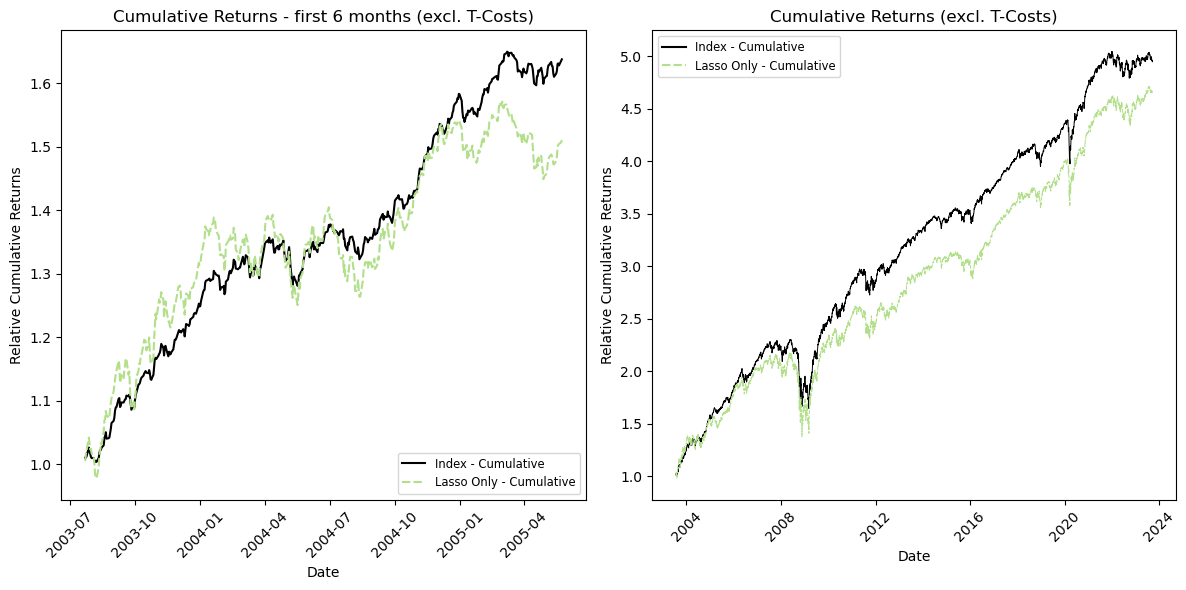

In [87]:
plt.figure(figsize=FIG_SIZE)

plt.subplot(1, 2, 1)
sns.lineplot(data=results[["Index - Cumulative", "Lasso Only - Cumulative"]][TOTAL_REBALANCE_DAYS:2*TOTAL_REBALANCE_DAYS + REBALANCE_PERIOD])   
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns - first 6 months (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize='small')

# Plot the cumulative returns
plt.subplot(1, 2, 2)
sns.lineplot(data=results[["Index - Cumulative", "Lasso Only - Cumulative"]][TOTAL_REBALANCE_DAYS:], linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Second Approach: Lasso as Feature Selector and Least Squares as Weight Optimizer

We will use the features computed in the previous approach but fine tune the weights to obtain better results

In [88]:
selected_indices = np.nonzero(lasso_best)[0]

# Extract corresponding features for non-zero weights in X_train and X_test
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

reg_ls = LinearRegression(positive=True)
reg_ls.fit(X_train_selected, Y_train)

coefficients_ls = reg_ls.coef_

LS_coeff = lasso_best

# Modify lasso_best with the non-zero coefficients from LS
print("Ratio of non-zero coefficients in Lasso to non-zero coefficients in LS:", len(coefficients_ls[coefficients_ls != 0])/len(coefficients_ls))
LS_coeff[selected_indices][coefficients_ls != 0] = coefficients_ls[coefficients_ls != 0]

LS_coeff = LS_coeff / np.sum(LS_coeff)

#get mean squared error for best alpha
zero = np.zeros_like(Y)
Y_pred_LS = np.dot(X_test, LS_coeff)
zero[TOTAL_REBALANCE_DAYS:] = Y_pred_LS
results["Lasso + Least Squares"] = zero

# Calculate the predicted cumulative return for nonnegative LS
cum_returns_LS = np.cumsum(Y_pred_LS)
zero[TOTAL_REBALANCE_DAYS:] = cum_returns_LS
results["Lasso + Least Squares - Cumulative"] = 1 + zero

# Store Metrics
metrics["Lasso + Least Squares"]["Tracking Error"] = np.std(cum_returns_LS - cum_returns_real)
metrics["Lasso + Least Squares"]["Relative Drawdown"] = compute_rel_drawdown(cum_returns_LS)
metrics["Lasso + Least Squares"]["T-Costs"] = implied_t_costs(LS_coeff, 0, ABS_TCOSTS, REL_TCOSTS)

Ratio of non-zero coefficients in Lasso to non-zero coefficients in LS: 0.8571428571428571


### Plot the results

Mean Squared Error for nonnegative LS on test set: 3.089729487217607e-05


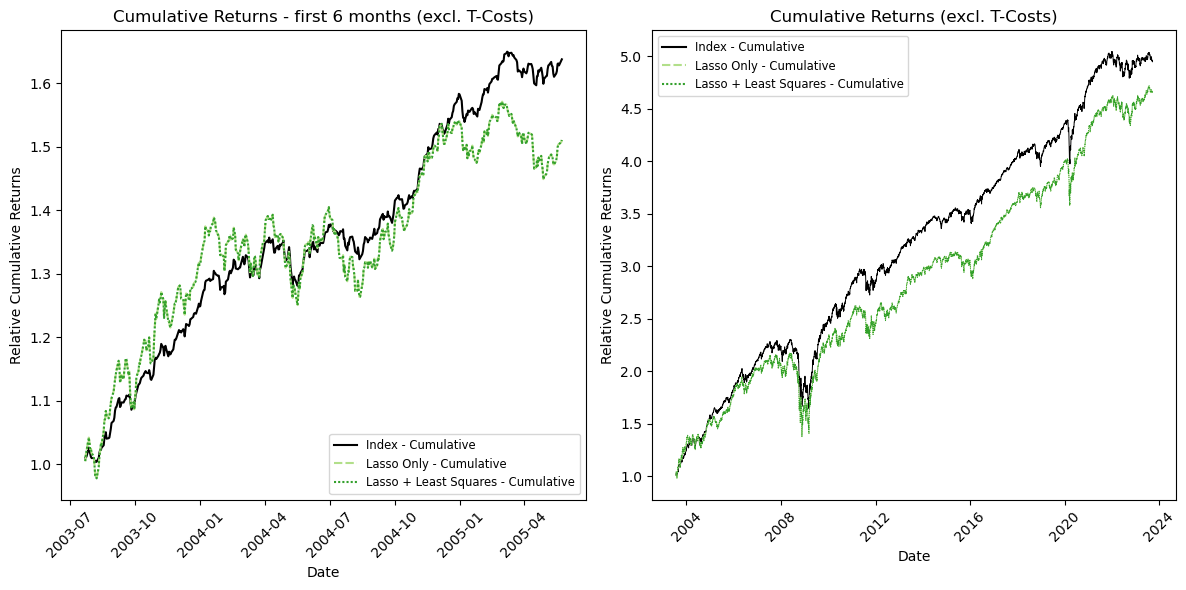

MSE for cumulative gains (portfolio value): 0.11704445646594938
MSE for cumulative losses (portfolio value): 2.2096403448406235e-07


In [89]:
# Evaluate the performance of the nonnegative LS model
msel_ls = mean_squared_error(Y_test, Y_pred_LS)
print(f"Mean Squared Error for nonnegative LS on test set: {msel_ls}")

plt.figure(figsize=(12, 6))

# Plot realized and predicted returns
plt.subplot(1, 2, 1)
sns.lineplot(data=results[["Index - Cumulative", "Lasso Only - Cumulative", "Lasso + Least Squares - Cumulative"]][TOTAL_REBALANCE_DAYS:2*TOTAL_REBALANCE_DAYS+REBALANCE_PERIOD])
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns - first 6 months (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize='small')

# Plot cumulative returns for realized and predicted
plt.subplot(1, 2, 2)
sns.lineplot(data=results[["Index - Cumulative", "Lasso Only - Cumulative", "Lasso + Least Squares - Cumulative"]][TOTAL_REBALANCE_DAYS:], linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pred_gains_LS = np.maximum(0, cum_returns_LS)
pred_losses_LS = np.minimum(0, cum_returns_LS)

# Calculate MSE for gains and losses
mse_gains_LS = mean_squared_error(gains, pred_gains_LS)
mse_losses_LS = mean_squared_error(losses, pred_losses_LS)

print("MSE for cumulative gains (portfolio value):", mse_gains_LS)
print("MSE for cumulative losses (portfolio value):", mse_losses_LS)

## Third Approach: Lasso whit Rebalancing

Based on the hyperparamter for rebalancing, this can be run with any rebalancing scenario.

The idea behind this approach is that one set of weights accross 20 years is probably not sufficient, therefore recomputing the optimal weights after a certain amount of days may lead to better results.

In [90]:
Y_pred_rebalance_lasso = []

# Collect t-costs, realized volatility and # parameters
t_costs = []
realized_vol = []
num_params = []
prev_weights = 0

for i in range(0, X.shape[0]-TOTAL_REBALANCE_DAYS, REBALANCE_PERIOD):

    rebalancing_window = TOTAL_REBALANCE_DAYS + i

    # For training, take the last TOTAL_REBALANCE_DAYS up to the current rebalancing window
    X_train_h, Y_train_h = X[(rebalancing_window - TOTAL_REBALANCE_DAYS):rebalancing_window], Y[(rebalancing_window - TOTAL_REBALANCE_DAYS):rebalancing_window]

    # For testing, take only the most recent rebalancing window
    X_test_h, Y_test_h = X[rebalancing_window:(rebalancing_window + REBALANCE_PERIOD)], Y[rebalancing_window:(rebalancing_window + REBALANCE_PERIOD)]

    # --------------------------- PICKING ALPHA:-------------------------------------

    folds = int(np.floor(days/REBALANCE_PERIOD))
    alpha = np.linspace(10e-6, 5*10e-5, folds * 70) 
    validation_itr = TimeSeriesSplit(n_splits=folds).split(X_train_h, Y_train_h)
    plot = False

    min_scorel = np.Infinity
    best_alpha = None

    # WITHOUT T COSTS, RUN ON REGRESSION1 FUNCTION
    for j, (train_idx, test_idx) in enumerate(validation_itr):
        w = regression1(X_train_h[train_idx], Y_train_h[train_idx], X_train_h[test_idx], Y_train_h[test_idx], alpha[j], plot)
        w = w / np.sum(w)
        # print(sum(w))
        Y_pred_lasso = np.dot(X_train_h[test_idx], w)

        # Evaluate the model (you can use appropriate metrics for your problem)
        msel = mean_squared_error(Y_train_h[test_idx], Y_pred_lasso)
        # print(f"Mean Squared Error for fold {j}: {msel}")

        cumreturns = np.cumsum(Y_pred_lasso)
        cummax = np.maximum.accumulate(cumreturns)
        drawdown = (cumreturns - cummax)/cummax
        drawdown = np.min(drawdown)

        num_nonzero_coeffsl = len(w[w != 0])
        # print(f"Number of non-zero coefficients for fold {j}: {num_nonzero_coeffsl}")

        scorel = (msel + drawdown)/2

        if scorel < min_scorel:
            min_scorel = scorel
            best_alpha = alpha[j]

    # -------------------------------------------------------------------------------

    lasso_best = regression1(X_train_h, Y_train_h, X_test_h, Y_test_h, best_alpha)

    lasso_best = lasso_best / np.sum(lasso_best)
    #print(f"Number of selected features: {np.count_nonzero(lasso_best)}")

    # Collect t-costs, realized volatility and # parameters
    t_costs.append(implied_t_costs(lasso_best, prev_weights, ABS_TCOSTS, REL_TCOSTS))
    realized_vol.append(np.std(Y_test_h))
    num_params.append(np.count_nonzero(lasso_best))

    Y_pred_lasso = np.dot(X_test_h, lasso_best)

    prev_weights = lasso_best


    if(len(Y_pred_lasso)>REBALANCE_PERIOD):
        Y_pred_rebalance_lasso.extend(list(Y_pred_lasso[:REBALANCE_PERIOD]))
    else:
        Y_pred_rebalance_lasso.extend(list(Y_pred_lasso))

    # print(Y_pred)
    # print("")
    # print(Y_pred_final)

zero = np.zeros_like(Y)
Y_pred_rebalance_lasso = np.array(Y_pred_rebalance_lasso)
zero[TOTAL_REBALANCE_DAYS:] = Y_pred_rebalance_lasso
results["Rebalancing and Lasso"] = zero


### Compute Evaluation Metrics

In [91]:
cum_returns_pred_final = np.cumsum(Y_pred_rebalance_lasso)
zero[TOTAL_REBALANCE_DAYS:] = cum_returns_pred_final
results["Rebalancing and Lasso - Cumulative"] = 1 + zero

pred_gains_fin, pred_losses_fin = compute_gains_losses(cum_returns_pred_final)

# Calculate MSE for gains and losses
mse_gains_fin = mean_squared_error(gains, pred_gains_fin)
mse_losses_fin = mean_squared_error(losses, pred_losses_fin)

print("MSE for cumulative gains (portfolio value):", mse_gains_fin)
print("MSE for cumulative losses (portfolio value):", mse_losses_fin)

# Calculate the drawdown for test set as before 
drawdown_test = compute_rel_drawdown(cum_returns_pred_final)

metrics["Rebalancing and Lasso"]["Tracking Error"] = np.std(cum_returns_pred_final - cum_returns_real)
metrics["Rebalancing and Lasso"]["Relative Drawdown"] = drawdown_test
metrics["Rebalancing and Lasso"]["T-Costs"] = np.sum(t_costs)
T_costs["Rebalancing and Lasso"] = t_costs

MSE for cumulative gains (portfolio value): 0.016629011315455168
MSE for cumulative losses (portfolio value): 1.3926884037693005e-08


### Plot the Results

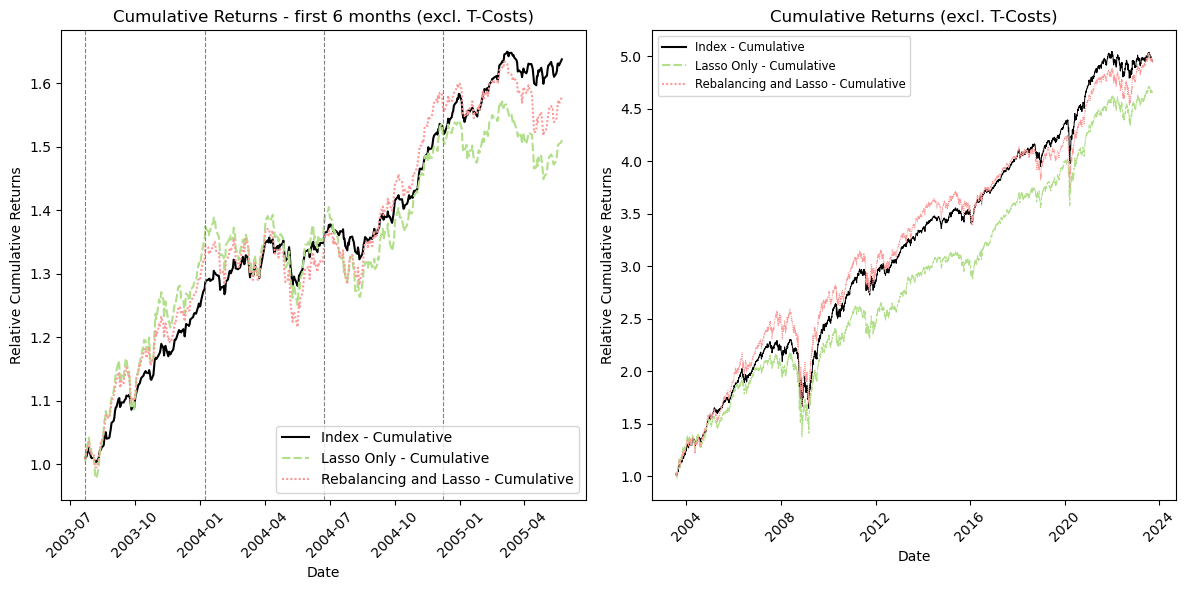

In [92]:
plt.figure(figsize=FIG_SIZE)

palette = ["Black"] + [sns.color_palette("Paired")[2]] + [sns.color_palette("Paired")[4]]

plt.subplot(1, 2, 2)
sns.lineplot(data=results[["Index - Cumulative", "Lasso Only - Cumulative", "Rebalancing and Lasso - Cumulative"]][TOTAL_REBALANCE_DAYS:], linewidth=0.7, palette=palette)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

# Plot the cumulative returns
plt.subplot(1, 2, 1)

sns.lineplot(data=results[["Index - Cumulative", "Lasso Only - Cumulative", "Rebalancing and Lasso - Cumulative"]][TOTAL_REBALANCE_DAYS:2*TOTAL_REBALANCE_DAYS + REBALANCE_PERIOD], palette=palette)

# Mark every 5*28 data points with a vertical line
for i in range(TOTAL_REBALANCE_DAYS, 2*TOTAL_REBALANCE_DAYS + REBALANCE_PERIOD, REBALANCE_PERIOD):
    plt.axvline(results.index.values[i], color='gray', linestyle='--', linewidth=0.8)

plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns - first 6 months (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize='small')

# Adjust legend font size
plt.legend(fontsize=8)

# Position the legend in the upper-left corner
plt.legend(loc='lower right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


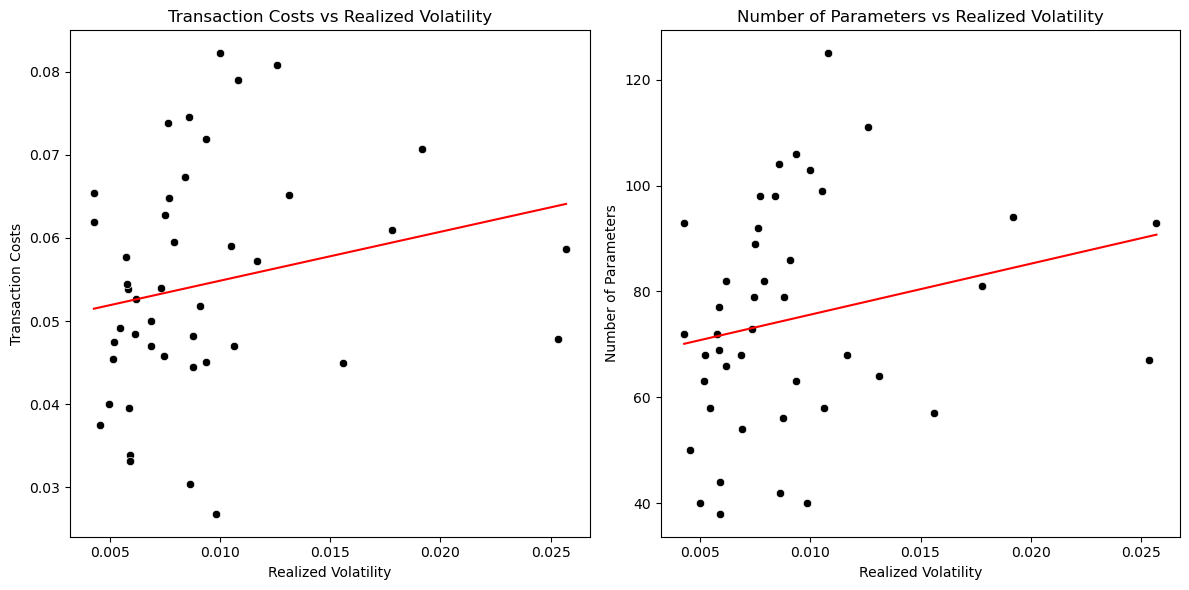

Tracking Error: 0.12895366142108555
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.005
Date:                Thu, 21 Dec 2023   Prob (F-statistic):              0.164
Time:                        12:19:02   Log-Likelihood:                 128.40
No. Observations:                  44   AIC:                            -252.8
Df Residuals:                      42   BIC:                            -249.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

In [93]:
plt.figure(figsize=FIG_SIZE)

# Plot the t-costs
def fit_curve(x, a, b):
    return a + b*x

params_t_costs, _ = curve_fit(fit_curve, realized_vol, t_costs)

plt.subplot(1, 2, 1)
sns.scatterplot(x=realized_vol, y=t_costs)
sns.lineplot(x=realized_vol, y=fit_curve(np.array(realized_vol), params_t_costs[0], params_t_costs[1]), color='red')
plt.xlabel('Realized Volatility')
plt.ylabel('Transaction Costs')
plt.title('Transaction Costs vs Realized Volatility')

# Plot the number of parameters

params_params, _ = curve_fit(fit_curve, realized_vol, num_params)

plt.subplot(1, 2, 2)
sns.scatterplot(x=realized_vol,y=num_params)
sns.lineplot(x=realized_vol, y=fit_curve(np.array(realized_vol), params_params[0], params_params[1]), color='red')
plt.xlabel('Realized Volatility')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters vs Realized Volatility')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

tracking_error = np.sqrt(compute_mse(cum_returns_pred_final, cum_returns_real))
print("Tracking Error:", tracking_error)
realized_vol_const = sm.add_constant(realized_vol)

print(sm.OLS(t_costs, realized_vol_const).fit().summary())

print(sm.OLS(num_params, realized_vol_const).fit().summary())


### Evaluate whether there was an improvement

In [94]:
if(mse_gains_fin < mse_gains):
    print("With rebalancing using Lasso we manage to reduce error on the gains")
else:
    print("With rebalancing using Lasso we DON'T manage to reduce error on the gains")

if(mse_losses_fin < mse_losses):
    print("With rebalancing using Lasso we manage to reduce error on the losses")
else:
    print("With rebalancing using Lasso we DON'T manage to reduce error on the losses")

With rebalancing using Lasso we manage to reduce error on the gains
With rebalancing using Lasso we manage to reduce error on the losses


## Fourth Approach: Lasso and Least Squares with Rebalancing

In [95]:
Y_pred_rebalancing_ls = []
curr_Y_pred = 0
t_costs_ls_reb = []

w_prev_ls = 0

for i in range(0, X.shape[0]-TOTAL_REBALANCE_DAYS, REBALANCE_PERIOD):
    # split_index_here = int(0.8 * len(X.T) + i)  # Use 80% of the data for training

    rebalancing_window = TOTAL_REBALANCE_DAYS + i
    # For training, take the last 5*28 up to split_index_here
    X_train_h, Y_train_h = X[(rebalancing_window - TOTAL_REBALANCE_DAYS):rebalancing_window], Y[(rebalancing_window - TOTAL_REBALANCE_DAYS):rebalancing_window]

    # For testing, take only 28 after split_index_here
    X_test_h, Y_test_h = X[rebalancing_window:(rebalancing_window + REBALANCE_PERIOD)], Y[rebalancing_window:(rebalancing_window + REBALANCE_PERIOD)]

    # X_train_h, X_test_h = X_train_h.T, X_test_h.T

    # --------------------------- PICKING ALPHA:-------------------------------------

    folds = int(np.floor(days/REBALANCE_PERIOD))
    alpha = np.linspace(10e-9, 5*10e-6, folds) 
    validation_itr = TimeSeriesSplit(n_splits=folds).split(X_train_h, Y_train_h)
    plot = False

    min_scorel = np.Infinity
    best_alpha = None

    # WITHOUT T COSTS, RUN ON REGRESSION1 FUNCTION
    for j, (train_idx, test_idx) in enumerate(validation_itr):
        curr_X_train = X_train_h[train_idx]
        curr_Y_train = Y_train_h[train_idx]
        curr_X_test = X_train_h[test_idx]
        curr_Y_test = Y_train_h[test_idx]

        w = regression1(curr_X_train, curr_Y_train, curr_X_test, curr_Y_train, alpha[j], plot)
        w = w / np.sum(w)
        # print(sum(w))
        curr_Y_pred = np.dot(curr_X_test, w)

        if np.isnan(curr_Y_test).any() or np.isnan(curr_X_test).any():
            if VERBOSE:
                print("Found a NaN in Y_train_h")
                print(Y_train_h[test_idx])
        
        if np.isnan(curr_Y_pred).any():
            if VERBOSE:
                print("Found a NaN in Y_pred")
                print(curr_Y_pred)
            continue
        msel = mean_squared_error(Y_train_h[test_idx], curr_Y_pred)

        if VERBOSE:
            print(f"Mean Squared Error for fold {j}: {msel}")

        drawdown = compute_rel_drawdown(curr_Y_pred)

        num_nonzero_coeffsl = len(w[w != 0])
        if VERBOSE:
            print(f"Number of non-zero coefficients for fold {j}: {num_nonzero_coeffsl}")

        scorel = (msel + drawdown)/2

        if scorel < min_scorel:
            min_scorel = scorel
            best_alpha = alpha[j]

        w_prev_ls = w

    # -------------------------------------------------------------------------------

    lasso_best = regression1(X_train_h, Y_train_h, X_test_h, Y_test_h, best_alpha)

    lasso_best = lasso_best / np.sum(lasso_best)
    if VERBOSE:
        print(f"Number of selected features: {np.count_nonzero(lasso_best)}")

    # ________________________________________________________________
    selected_indices_h = np.nonzero(lasso_best)[0]

    if VERBOSE:
        print("Length of selected_indices_h = ", len(selected_indices_h))

    # Extract corresponding features for non-zero weights in X_train and X_test
    X_train_selected_h = X_train_h[:, selected_indices_h]
    X_test_selected_h = X_test_h[:, selected_indices_h]

    if VERBOSE: 
        print("Shape of X_train_selected_h = ", X_train_selected_h.shape)

    reg_ls = LinearRegression(positive=True)  # Assuming you have a LinearRegression implementation that supports nonnegativity
    reg_ls.fit(X_train_selected_h, Y_train_h)

    coefficients_ls = reg_ls.coef_

    if VERBOSE:
        print("Length of reg_ls.coef_ = ", len(reg_ls.coef_))


    LS_coeff_h = lasso_best

    if (sum(coefficients_ls != 0) < np.count_nonzero(lasso_best)):
        LS_coeff_h = lasso_best
        if VERBOSE:
            print("DOING LASSO INSTEAD!")

    else:
        # Modify lasso_best with the non-zero coefficients from LS
        LS_coeff_h[selected_indices_h] = coefficients_ls[coefficients_ls != 0]


    LS_coeff_h = LS_coeff_h / np.sum(LS_coeff_h)

    Y_pred = np.dot(X_test_h, LS_coeff_h)
    t_costs_ls_reb.append(implied_t_costs(LS_coeff_h, w_prev_ls, ABS_TCOSTS, REL_TCOSTS))

    if(len(Y_pred)>REBALANCE_PERIOD):
        Y_pred_rebalancing_ls.extend(list(Y_pred[:REBALANCE_PERIOD]))
    else:
        Y_pred_rebalancing_ls.extend(list(Y_pred))
    
    if VERBOSE:
        print(Y_pred)
        print("")
        print(Y_pred_rebalancing_ls)

zero = np.zeros_like(Y)
Y_pred_rebalancing_ls = np.array(Y_pred_rebalancing_ls)
zero[TOTAL_REBALANCE_DAYS:] = Y_pred_rebalancing_ls
results["Rebalancing and Lasso + Least Squares"] = zero

### Evaluation Metrics

In [96]:
# # -----------------------------------------------------------------------------
from re import T


cum_returns_pred_final_LS = np.cumsum(Y_pred_rebalancing_ls)
zero[TOTAL_REBALANCE_DAYS:] = cum_returns_pred_final_LS
results["Rebalancing and Lasso + Least Squares - Cumilative"] = 1 + zero

if np.isnan(cum_returns_pred_final_LS).any():
    print("Found a NaN in cum_returns_pred_final_LS")
    display(cum_returns_pred_final_LS)

pred_gains_fin_LS, pred_losses_fin_LS = compute_gains_losses(cum_returns_pred_final_LS)

gains, losses = compute_gains_losses(cum_returns_real)

# Calculate MSE for gains and losses
mse_gains_fin_LS = mean_squared_error(gains, pred_gains_fin_LS)
mse_losses_fin_LS = mean_squared_error(losses, pred_losses_fin_LS)
total_mse = mean_squared_error(cum_returns_real, cum_returns_pred_final_LS)

print("MSE for cumulative gains (portfolio value):", mse_gains_fin_LS)
print("MSE for cumulative losses (portfolio value):", mse_losses_fin_LS)
print("Total MSE:", total_mse)

# Calculate the drawdown for test set as before 
drawdown_test = compute_rel_drawdown(cum_returns_pred_final_LS)



metrics["Rebalancing and Lasso + Least Squares"]["Tracking Error"] = np.std(cum_returns_pred_final_LS - cum_returns_real)
metrics["Rebalancing and Lasso + Least Squares"]["Relative Drawdown"] = drawdown_test
metrics["Rebalancing and Lasso + Least Squares"]["T-Costs"] = np.sum(t_costs_ls_reb)

T_costs["Rebalancing and Lasso + Least Squares"] = t_costs_ls_reb

MSE for cumulative gains (portfolio value): 0.04320160481734889
MSE for cumulative losses (portfolio value): 2.2096403448406235e-07
Total MSE: 0.04320192926223776


### Verifying whether the method has improved the results

In [97]:
if(mse_gains_fin_LS < mse_gains_LS):
    print("With rebalancing using Lasso + LS we manage to reduce error on the gains")
else:
    print("With rebalancing using Lasso + LS we DON'T manage to reduce error on the gains")

if(mse_losses_fin_LS < mse_losses_LS):
    print("With rebalancing using Lasso + LS we manage to reduce error on the losses")
else:
    print("With rebalancing using Lasso + LS we DON'T manage to reduce error on the losses")

With rebalancing using Lasso + LS we manage to reduce error on the gains
With rebalancing using Lasso + LS we DON'T manage to reduce error on the losses


### Plotting the Results

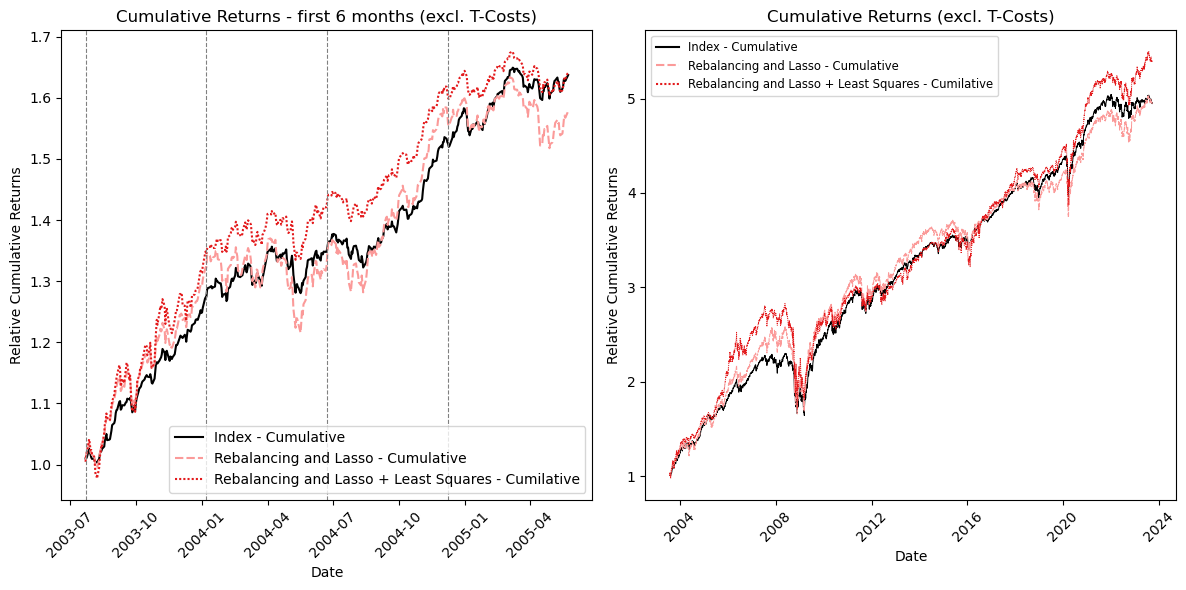

In [98]:
plt.figure(figsize=FIG_SIZE)

palette = ["Black"] + [sns.color_palette("Paired")[4]] + [sns.color_palette("Paired")[5]]

plt.subplot(1, 2, 2)

# Plot the cumulative returns across the whole time period
sns.lineplot(data=results[["Index - Cumulative", "Rebalancing and Lasso - Cumulative", "Rebalancing and Lasso + Least Squares - Cumilative"]][TOTAL_REBALANCE_DAYS:], palette=palette, linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

plt.subplot(1, 2, 1)
# Plot the cumulative returns
sns.lineplot(data=results[["Index - Cumulative", "Rebalancing and Lasso - Cumulative", "Rebalancing and Lasso + Least Squares - Cumilative"]][TOTAL_REBALANCE_DAYS:2*TOTAL_REBALANCE_DAYS + REBALANCE_PERIOD], palette=palette)

# Mark every 5*28 data points with a vertical line
for i in range(TOTAL_REBALANCE_DAYS, 2*TOTAL_REBALANCE_DAYS + REBALANCE_PERIOD, REBALANCE_PERIOD):
    plt.axvline(results.index.values[i], color='gray', linestyle='--', linewidth=0.8)

plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns - first 6 months (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize='small')

# Adjust legend font size
plt.legend(fontsize=8)

# Position the legend in the upper-left corner
plt.legend(loc='lower right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## All Methods Plotted

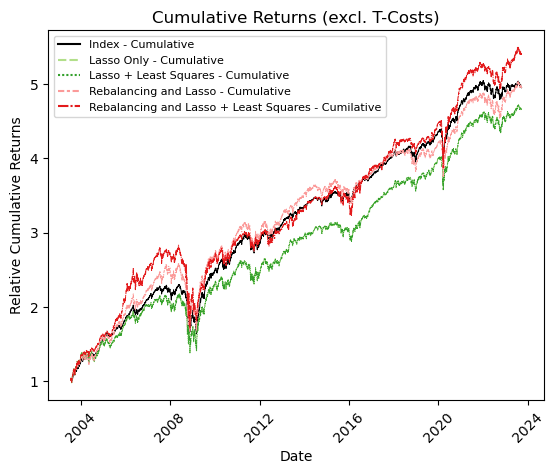

In [99]:
sns.lineplot(data=results[["Index - Cumulative", "Lasso Only - Cumulative", "Lasso + Least Squares - Cumulative", "Rebalancing and Lasso - Cumulative", "Rebalancing and Lasso + Least Squares - Cumilative"]][TOTAL_REBALANCE_DAYS:], linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(fontsize=8)

## Plotting Best

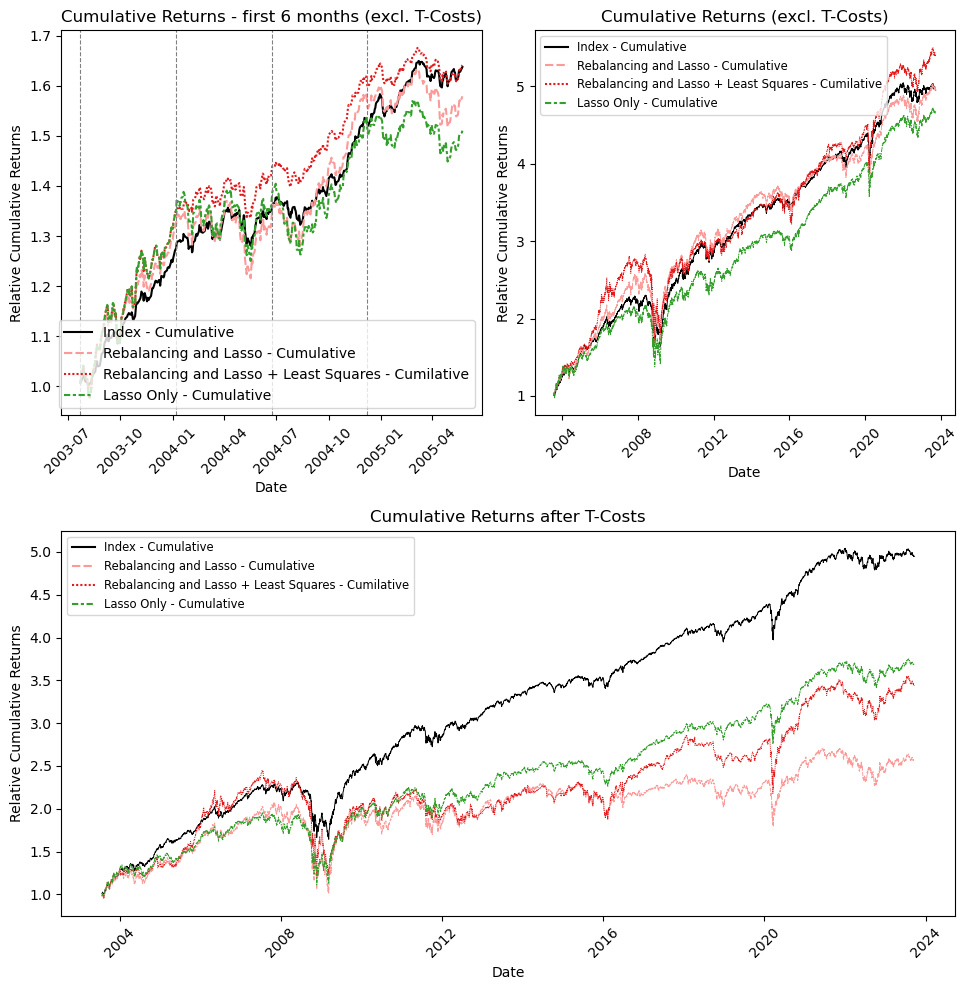

In [106]:
plt.figure(figsize=(10,10))

features = ["Index - Cumulative", "Rebalancing and Lasso - Cumulative", "Rebalancing and Lasso + Least Squares - Cumilative", 'Lasso Only - Cumulative']

palette = ["Black"] + [sns.color_palette("Paired")[4]] + [sns.color_palette("Paired")[5]] + [sns.color_palette("Paired")[3]]

plt.subplot(2, 2, 2)

# Plot the cumulative returns across the whole time period
sns.lineplot(data=results[features][TOTAL_REBALANCE_DAYS:], palette=palette, linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

plt.subplot(2, 2, 1)
# Plot the cumulative returns
sns.lineplot(data=results[features][TOTAL_REBALANCE_DAYS:2*TOTAL_REBALANCE_DAYS + REBALANCE_PERIOD], palette=palette)

# Mark every 5*28 data points with a vertical line
for i in range(TOTAL_REBALANCE_DAYS, 2*TOTAL_REBALANCE_DAYS + REBALANCE_PERIOD, REBALANCE_PERIOD):
    plt.axvline(results.index.values[i], color='gray', linestyle='--', linewidth=0.8)

plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns - first 6 months (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize='small')

# Adjust legend font size
plt.legend(fontsize=8)

# Position the legend in the upper-left corner
plt.legend(loc='lower right')

plt.subplot(2, 2, (3,4))
t_costs_rebal = pd.DataFrame(columns=features)

t_costs_rebal["Rebalancing and Lasso - Cumulative"] = T_costs["Rebalancing and Lasso"]
t_costs_rebal['Rebalancing and Lasso + Least Squares - Cumilative'] = T_costs["Rebalancing and Lasso + Least Squares"]
t_costs_rebal['Lasso Only - Cumulative'] = np.repeat(metrics["Lasso Only"]["T-Costs"], len(T_costs["Rebalancing and Lasso"]))
t_costs_rebal['Index - Cumulative'] = 0

t_costs_sum = t_costs_rebal.cumsum(axis=0)

tc = pd.DataFrame(columns=features, index=returns.index)
for i, j in zip(np.arange(TOTAL_REBALANCE_DAYS, len(returns.index), REBALANCE_PERIOD), t_costs_sum.index.values):
    tc.loc[tc.index.values[i]] = t_costs_sum.loc[t_costs_sum.index.values[j]]

tc.fillna(method='ffill', inplace=True)
tc.fillna(0, inplace=True)

sns.lineplot(data=results[features][TOTAL_REBALANCE_DAYS:]-tc[features][TOTAL_REBALANCE_DAYS:], palette=palette, linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns after T-Costs')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

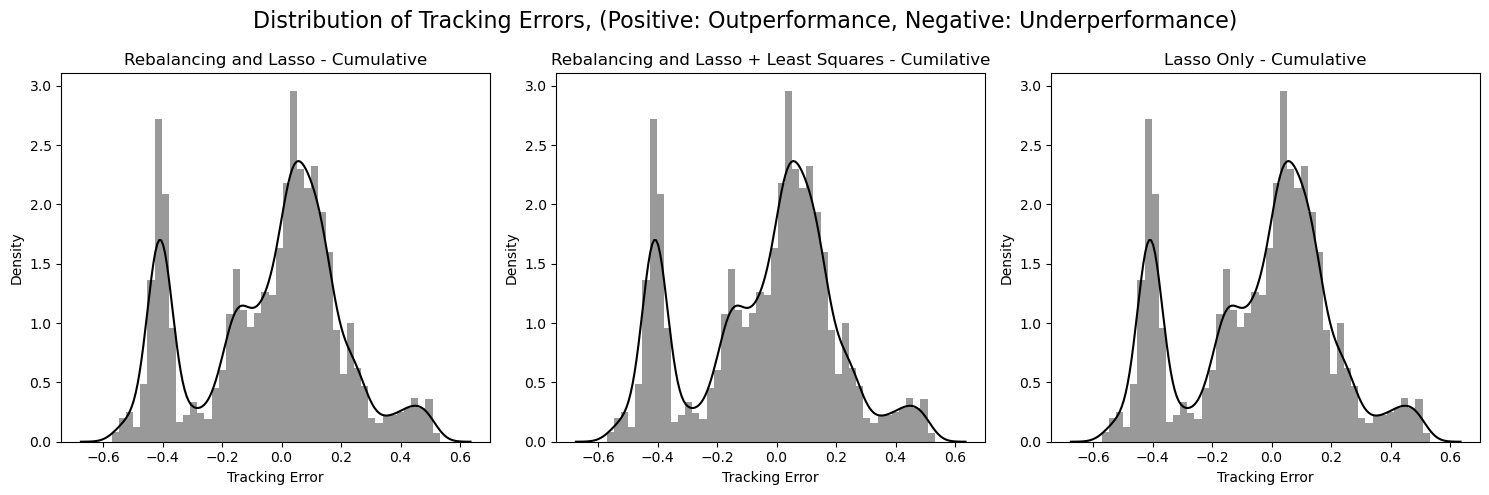

In [108]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)
fig.tight_layout(pad=3.0)
for j in range(3):
    features = ["Rebalancing and Lasso - Cumulative", "Rebalancing and Lasso + Least Squares - Cumilative", 'Lasso Only - Cumulative']
    data = results[features].values - np.tile(results["Index - Cumulative"].values, (3,1)).T
    sns.distplot(data[TOTAL_REBALANCE_DAYS:], ax=axs[j])
    axs[j].set_title(features[j])
    axs[j].set_xlabel('Tracking Error')

fig.suptitle('Distribution of Tracking Errors, (Positive: Outperformance, Negative: Underperformance)', fontsize=16)
fig.set_tight_layout(True)

## Metrics for All Methods

In [101]:
display(metrics)
metrics.to_excel("metrics.xlsx")

,Lasso Only,Lasso + Least Squares,Rebalancing and Lasso,Rebalancing and Lasso + Least Squares
Tracking Error,0.154808,0.154808,0.1228,0.156004
Relative Drawdown,1.540738,1.540738,1.152955,1.540738
T-Costs,0.022,0.022,2.392433,1.943413
